### Fake News Detection Using RNN and LSTM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path

import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
#import torchvision
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, tqdm_notebook

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
DATA_PATH = '/content/drive/MyDrive/DATA690FinalProject/data/train.csv'

In [5]:
class Sequences(Dataset):
    def __init__(self, path, max_seq_len):
        self.max_seq_len = max_seq_len
        df = pd.read_csv(path)
        df = df.dropna(axis=0)
        vectorizer = CountVectorizer(stop_words='english', min_df=0.015)
        vectorizer.fit(df.text.tolist())
        
        self.token2idx = vectorizer.vocabulary_
        self.token2idx[''] = max(self.token2idx.values()) + 1

        tokenizer = vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x)
                                 if token in self.token2idx]
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['']]
        
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df.text.tolist()]
        sequences, self.labels = zip(*[(sequence, label) for sequence, label
                                    in zip(sequences, df.label.tolist()) if sequence])
        self.sequences = [self.pad(sequence) for sequence in sequences]

    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)

In [6]:
dataset = Sequences(DATA_PATH, max_seq_len=128)

In [7]:
train, test = torch.utils.data.random_split(dataset,[5000, 13205])
val, test = torch.utils.data.random_split(test,[5000, 8205])

In [8]:
len(dataset.token2idx)
len(dataset)

18205

In [9]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.FloatTensor([item[1] for item in batch])
    return inputs, target

batch_size = 5000
data  = DataLoader(train, batch_size=batch_size, collate_fn=collate)
val = DataLoader(val, batch_size=batch_size, collate_fn=collate)

In [10]:
data, val

(<torch.utils.data.dataloader.DataLoader at 0x7f1c77ddcc10>,
 <torch.utils.data.dataloader.DataLoader at 0x7f1c77ddcb80>)

####RNN

In [11]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        batch_size,
        embedding_dimension=100,
        hidden_size=128, 
        n_layers=1,
        device='cpu',
    ):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.batch_size = batch_size
        
        self.encoder = nn.Embedding(vocab_size, embedding_dimension)
        self.rnn = nn.GRU(
            embedding_dimension,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
        self.decoder = nn.Linear(hidden_size, 1)
        
    def init_hidden(self):
        return torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device)
    
    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
            
        encoded = self.encoder(inputs)
        output, hidden = self.rnn(encoded, self.init_hidden())
        output = self.decoder(output[:, :, -1]).squeeze()
        return output

In [12]:
model = RNN(
    hidden_size=128,
    vocab_size=len(dataset.token2idx),
    device=device,
    batch_size=batch_size,
)
model = model.to(device)
model

RNN(
  (encoder): Embedding(3570, 100)
  (rnn): GRU(100, 128, batch_first=True)
  (decoder): Linear(in_features=128, out_features=1, bias=True)
)

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)

In [14]:


model.train()
train_losses = []
for epoch in range(25):
  progress_bar = tqdm_notebook(data, leave=False)
  losses = []
  total = 0
  for inputs, target in progress_bar:
    inputs, target = inputs.to(device), target.to(device)
    model.zero_grad()
    
    output = model(inputs)

    loss = criterion(output, target)
    
    loss.backward()
          
    nn.utils.clip_grad_norm_(model.parameters(), 3)

    optimizer.step()
    
    progress_bar.set_description(f'Loss: {loss.item():.3f}')
    
    losses.append(loss.item())
    total += 1
  
  epoch_loss = sum(losses) / total
  train_losses.append(epoch_loss)

  tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')

<ipython-input-14-22e0c669e35a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(data, leave=False)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #1	Train Loss: 0.713


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #2	Train Loss: 0.704


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #3	Train Loss: 0.699


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #4	Train Loss: 0.694


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #5	Train Loss: 0.693


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #6	Train Loss: 0.691


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #7	Train Loss: 0.690


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #8	Train Loss: 0.687


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #9	Train Loss: 0.685


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #10	Train Loss: 0.683


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #11	Train Loss: 0.680


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #12	Train Loss: 0.677


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #13	Train Loss: 0.675


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #14	Train Loss: 0.672


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #15	Train Loss: 0.670


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #16	Train Loss: 0.667


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #17	Train Loss: 0.663


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #18	Train Loss: 0.660


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #19	Train Loss: 0.656


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #20	Train Loss: 0.650


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #21	Train Loss: 0.643


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #22	Train Loss: 0.636


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #23	Train Loss: 0.627


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #24	Train Loss: 0.618


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #25	Train Loss: 0.606


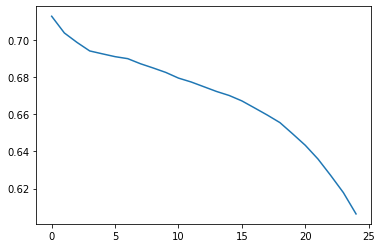

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(train_losses)

- In the above graph we can see that the loss percentage reduced by more than 10% in 25 epochs. This is a good enough reduction in loss percentage.

In [16]:
#progress_bar = tqdm_notebook(val, leave=False)
target_list = []
pred_list = []
#m = nn.Sigmoid()
for inputs, target in val:
  inputs, target = inputs.to(device), target.to(device)
  target_list.append(target.tolist())
  model.zero_grad()
  
  preds = model(inputs)
  #preds = m(preds)
  print(preds)
  pred_list.append(preds.detach().tolist())

tensor([ 0.7623,  0.4737, -0.0734,  ..., -0.4597, -0.1028, -0.7369],
       device='cuda:0', grad_fn=<SqueezeBackward0>)


In [17]:
len(pred_list[0]), len(target_list[0])

(5000, 5000)

In [18]:
y_pred = list()
for i in pred_list[0]:
  y_pred.append(i)
y_target = list()
for i in target_list[0]:
  y_target.append(i)


In [19]:
for i in range(len(y_pred)):
  if(y_pred[i]<0.45):
    y_pred[i]= 0.0
  else:
    y_pred[i]= 1.0
    

In [20]:

from sklearn.metrics import classification_report


print(classification_report(y_true=y_target, y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.64      0.92      0.76      2848
         1.0       0.76      0.32      0.45      2152

    accuracy                           0.66      5000
   macro avg       0.70      0.62      0.60      5000
weighted avg       0.69      0.66      0.63      5000



- We can see above that the RNN model works well for us as it is able to provide accuracy of 66%.

- Moreover, it is able to capture instances of both real (0) and fake (1) news with more that 60% precision.

In the foloowing section we try to implement the LSTM model to compare its performance against RNN.

# LSTM

In [21]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        batch_size=5000,
        embedding_dimension=100,
        hidden_size=128, 
        n_layers=1,
        device='cuda',
    ):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.batch_size = batch_size
        
        self.encoder = nn.Embedding(embedding_dim=128, num_embeddings=len(dataset.token2idx), padding_idx=3)
        self.lstm = nn.LSTM(input_size=128,hidden_size= 10,num_layers=2, batch_first=True)
        self.decoder = nn.Linear(10, 1)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout_layer = nn.Dropout(p=0.2)
        
    def init_hidden(self):
        return torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device)
    
    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        #print('Before Embedding',inputs.shape)    
        encoded = self.encoder(inputs)
        #print('After Embedding Before LSTM',encoded.shape)
        #output, hidden = self.lstm(encoded)
       
        # output= self.lstm(encoded)
        # print('After LSTM Before Linear',len(output))
        # output = self.decoder(output[0])#.squeeze()




        outputs, (ht, ct) = self.lstm(encoded)
		    # ht is the last hidden state of the sequences
        # ht = (1 x batch_size x hidden_dim)
        # ht[-1] = (batch_size x hidden_dim)
        #output = self.dropout_layer(ht[-1])
        output = self.decoder(ht[-1])
        #output = self.softmax(output)


        return output

In [22]:
model = LSTM(
    hidden_size=128,
    vocab_size=len(dataset.token2idx),
    device=device,
    batch_size=5000,
)
model = model.to(device)
model

LSTM(
  (encoder): Embedding(3570, 128, padding_idx=3)
  (lstm): LSTM(128, 10, num_layers=2, batch_first=True)
  (decoder): Linear(in_features=10, out_features=1, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout_layer): Dropout(p=0.2, inplace=False)
)

In [23]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)

In [24]:
for i in data:
  print(i)

(tensor([[2941, 2427,  376,  ..., 2095, 2172,  545],
        [3260, 1438,  356,  ..., 2351,  863, 1964],
        [1115, 3254, 2437,  ...,  534, 1173, 3260],
        ...,
        [ 879, 1323, 2844,  ..., 1323, 2358, 3423],
        [1106, 1851, 1801,  ..., 3395, 2377, 3416],
        [ 402,  610, 2872,  ..., 3213, 1215, 2042]]), tensor([0., 0., 1.,  ..., 0., 0., 0.]))


In [25]:
len(dataset.token2idx)

3570

In [26]:
m = nn.Embedding(embedding_dim=128, num_embeddings=len(dataset.token2idx), padding_idx=3)
l = nn.LSTM(input_size=128,hidden_size= 10,num_layers=2, batch_first=True,)
o= nn.Linear(10, 1)
d = nn.Dropout(p=0.2)
for text, target in data:
  output = m(text)
  outputs, (ht, ct)= l(output)
  output = d(ht[-1])
  #output = o(output[0])
  print(output.shape)

torch.Size([5000, 10])


In [27]:
from pylab import *

model.train()
train_losses = []
for epoch in range(25):
  progress_bar = tqdm_notebook(data, leave=False)
  losses = []
  total = 0
  for inputs, target in progress_bar:
    inputs, target = inputs.to(device), target.to(device)
    target=target.unsqueeze(1)
    model.zero_grad()
    
    output = model(inputs)
    #print(output)
    #print(output.shape, target.shape)
    loss = criterion(output, target)
    
    loss.backward()
          
    nn.utils.clip_grad_norm_(model.parameters(), 3)

    optimizer.step()
    
    progress_bar.set_description(f'Loss: {loss.item():.3f}')
    
    losses.append(loss.item())
    total += 1
  
  epoch_loss = sum(losses) / total
  train_losses.append(epoch_loss)

  tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')

<ipython-input-27-f5f673749b28>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(data, leave=False)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #1	Train Loss: 0.684


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #2	Train Loss: 0.683


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #3	Train Loss: 0.682


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #4	Train Loss: 0.681


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #5	Train Loss: 0.681


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #6	Train Loss: 0.680


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #7	Train Loss: 0.679


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #8	Train Loss: 0.678


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #9	Train Loss: 0.678


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #10	Train Loss: 0.677


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #11	Train Loss: 0.676


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #12	Train Loss: 0.676


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #13	Train Loss: 0.675


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #14	Train Loss: 0.674


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #15	Train Loss: 0.673


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #16	Train Loss: 0.672


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #17	Train Loss: 0.671


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #18	Train Loss: 0.670


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #19	Train Loss: 0.669


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #20	Train Loss: 0.668


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #21	Train Loss: 0.667


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #22	Train Loss: 0.666


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #23	Train Loss: 0.665


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #24	Train Loss: 0.664


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #25	Train Loss: 0.662


- If we compare the loss reduction rate with RNN, we can see that using LSTM we are not able to achieve the desired loss reduction.

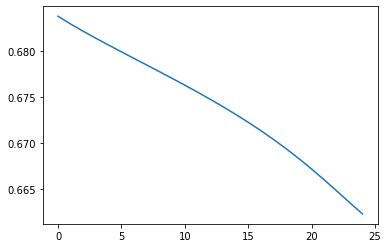

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(train_losses)

In [29]:
target_list = []
pred_list = []
#m = nn.Sigmoid()
for inputs, target in val:
  inputs, target = inputs.to(device), target.to(device)
  target_list.append(target.tolist())
  model.zero_grad()
  
  preds = model(inputs)
  #preds = m(preds)
  print(preds)
  pred_list.append(preds.detach().tolist())

tensor([[ 0.0202],
        [-0.2938],
        [-0.5448],
        ...,
        [-0.4121],
        [-0.3058],
        [-0.3475]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [30]:
len(pred_list[0]), len(target_list[0])

(5000, 5000)

In [31]:
y_pred = list()
y_target = list()
for i in target_list[0]:
  y_target.append(i)

for i in range(len(pred_list[0])):
  #print(i)
  y_pred.append(pred_list[0][i][0])


In [32]:
y_pred

[0.020213067531585693,
 -0.2938377261161804,
 -0.544763445854187,
 -0.3219255805015564,
 -0.3855052888393402,
 0.016078650951385498,
 -0.39204758405685425,
 0.020218253135681152,
 -0.4064047336578369,
 -0.42035648226737976,
 -0.3964693248271942,
 -0.23094859719276428,
 0.020057976245880127,
 -0.3539297878742218,
 -0.3223152160644531,
 -0.4040105640888214,
 -0.3075813055038452,
 0.017458409070968628,
 -0.3097931742668152,
 -0.3736932575702667,
 0.02016448974609375,
 0.020218372344970703,
 -0.2632581293582916,
 -0.40567776560783386,
 0.0197734534740448,
 -0.4015480577945709,
 -0.3230142295360565,
 -0.4173438549041748,
 0.017365872859954834,
 0.02022048830986023,
 0.01999986171722412,
 0.020215094089508057,
 0.011062026023864746,
 0.020209789276123047,
 0.020050108432769775,
 -0.34929603338241577,
 -0.3104248642921448,
 0.020078659057617188,
 0.020219355821609497,
 -0.3498869240283966,
 -0.2874056398868561,
 0.018535584211349487,
 -0.32777509093284607,
 -0.3280087411403656,
 -0.2282390892

In [33]:
for i in range(2):
  print(type(y_pred[i]))

<class 'float'>
<class 'float'>


In [34]:
for i in range(len(y_pred)):
  if(y_pred[i] < 0.45):
    y_pred[i]= 0.0
  else:
    y_pred[i]= 1.0 
    

In [35]:
len(y_target), len(y_pred)

(5000, 5000)

In [36]:

from sklearn.metrics import classification_report


print(classification_report(y_true=y_target, y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73      2848
         1.0       0.00      0.00      0.00      2152

    accuracy                           0.57      5000
   macro avg       0.28      0.50      0.36      5000
weighted avg       0.32      0.57      0.41      5000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- We can see above that LSTM gives accuracy of 57% only. Moreover, LSTM in our case is not able to capture instances of fake news (1) but captures instances of real news (0) with 57% precision.

Overall, even after tuning several hyperparameters such as learning rate and batch size, and number of epochs, RNN model performed better for us compared to LSTM on tabular data.